# Import

In [1]:

import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
import seaborn as sns


# Functions

In [2]:
def normalize_and_hv(Adata):

    #normalization and hv genes
    sc.pp.normalize_total(Adata,target_sum=1e6)
    sc.pp.log1p(Adata)
    sc.pp.highly_variable_genes(Adata, min_mean=0.0125, max_mean=3, min_disp=0.5, inplace=True)
    values, counts = np.unique(Adata.var['highly_variable'].values, return_counts = True)
    print(f'Number of highly variable genes: {counts[1]}')


In [3]:
def add_cluster_and_umap(Adata):

    if "highly_variable" not in Adata.var:
        sc.pp.highly_variable_genes(Adata)

    Adata_hv = Adata[:, Adata.var.highly_variable].copy()
    sc.tl.pca(Adata_hv, svd_solver='arpack')
    sc.pp.neighbors(Adata_hv, metric='correlation')  
    sc.tl.leiden(Adata_hv, resolution=0.5)
    sc.tl.umap(Adata_hv)
    Adata.obs['cluster'] = Adata_hv.obs['leiden']
    Adata.obsm['X_umap'] = Adata_hv.obsm['X_umap']
    day_palette = sns.color_palette("rocket", n_colors=Adata.obs['day'].nunique())
    Adata.uns['day_colors'] = [mcolors.to_hex(c) for c in day_palette]
    #sc.pl.umap(Adata, color=['day','cluster'], title = ['Days','Cluster'])

In [4]:
def remove_small_clusters(Adata):
    total_cells = len(Adata)
    clusters, counts = np.unique(Adata.obs["cluster"], return_counts=True)
    min_cells = total_cells * 0.01
    clusters_to_remove = clusters[counts < min_cells]
    Adata = Adata[~Adata.obs["cluster"].isin(clusters_to_remove), :]
    print(np.unique(Adata.obs["cluster"], return_counts=True))

    return Adata
    

In [5]:
def rename_clusters(Adata, Pluripotency_dict):
    
    sorted_clusters = sorted(Pluripotency_dict, key=Pluripotency_dict.get)
    cluster_rename_map = {old: str(new) for new, old in enumerate(sorted_clusters)}
    Adata.obs['cluster'] = Adata.obs['cluster'].astype(str).replace(cluster_rename_map)
    Adata.obs['cluster'] = Adata.obs['cluster'].astype(int) + 1
    Adata.obs['cluster'] = Adata.obs['cluster'].astype(str)

    cluster_palette = sns.color_palette("Set2", n_colors=Adata.obs['cluster'].nunique())
    Adata.uns['cluster_colors'] = [mcolors.to_hex(c) for c in cluster_palette]

    return Adata

In [6]:
def sort_days(item):
    if item == 'mESCs':
        return (float('inf'), item)
    
    return (int(item), item)

In [7]:
def stackbar_days(Adata):

    sorted_days = sorted(np.unique(Adata.obs.day), key=sort_days)
    sorted_clusters = sorted(Adata.obs.cluster.unique())

    #days in different clusters
    df_cluster = pd.DataFrame(columns=sorted_days, index=sorted_clusters)

    for c in sorted_clusters:
        for d in sorted_days:
            df_cluster.loc[c,d]=len(Adata[(Adata.obs.day == d)&(Adata.obs.cluster == c)])
            

    df_cluster = df_cluster.div(df_cluster.sum(axis=1), axis=0)

    ax = df_cluster.plot(kind='bar', stacked=True, title='Days per cluster', colormap = 'rocket')
    ax.set_ylabel('Days fraction')  
    ax.legend(title='Days', loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()

In [8]:
def import_differentiation_markers():

    #import gene clusters they used in the article
    df = pd.read_excel('../Datasets/Tran_genes_excel.xlsx')
    new_header = df.iloc[1]  
    df = df[2:]  
    df.columns = new_header  
    df.reset_index(drop=True, inplace=True) 

    #Remove problematic genes
    to_delete = df[df.index == 1739]
    df = df.drop(to_delete.index)
    genes_todelete = ['H2.D1', 'Rpl14.ps1', 'X1110038B12Rik', 'X1500012F01Rik', 'X1500015O10Rik', 'X1810058I24Rik', 'X2010111I01Rik', 'X2310022B05Rik', 'X2410006H16Rik', 'X2410015M20Rik', 'X2610305D13Rik', 'X2700094K13Rik', 'X2810004N23Rik', 'X2810417H13Rik', 'X3110039I08Rik', 'X9530068E07Rik']
    df = df.loc[~df['Gene Name'].isin(genes_todelete)]

    #make dictionary of marker genes, were keys are letters associated to different functions
    markers_dict = {}
    for index, row in df.iterrows():
        key = str(row['Group'])
        value = str(row['Gene Name'])
        if key in markers_dict :
            markers_dict[key].append(value)
        else :
            markers_dict[key] = [value]

    #make a subdictionary diff_markers containing just differentiation markers, values is an array of names of differentiation genes
    keys = ['A','B','C','D']
    diff_markers = {key: markers_dict[key] for key in keys}
    values = [i for list in diff_markers.values() for i in list]

    return diff_markers, values

In [9]:
def compute_pluripotency(Adata, Genes):

    sc.tl.score_genes(Adata, Genes)
    scores = Adata.obs['score'].values
    Pluripotency = 1. - scores/np.max(scores)

    Adata.obs['pluripotency'] = Pluripotency

In [10]:
def compute_naive_pluripotency(Adata, Genes):

    #Subsample adata selecting just differentiation genes
    Adata_diff = Adata[:, Genes]

    #create vector containing mean expression levels
    m = np.mean(Adata_diff.X, axis = 1)
    Pluripotency = 1 - m/m.max()

    Adata.obs['naive_pluripotency'] = Pluripotency


In [11]:
def cluster_naive_pluripotency(Adata, Genes):

    #Subsample adata selecting just differentiation genes
    Adata_diff = Adata[:, Genes]

    #CREATE DICTIONARY PLURIPOTENCY : keys=cluster_names, values = mean gene expression
    vals = []
    diff_level = {}

    for c in sorted(Adata.obs.cluster.unique()):
        val = np.mean(Adata_diff[Adata_diff.obs.cluster == c].X)
        vals.append(val)
        diff_level[c]=val
        
    val_max = max(vals) 

    for key in diff_level:
        diff_level[key] = 1 - diff_level[key]/val_max

    Pluripotency = diff_level

    Pluripotency = dict(sorted(Pluripotency.items(), key=lambda item: item[1]))
    Pluripotency_rounded = {k: round(v, 2) for k, v in Pluripotency.items()}

    Adata.obs["pluripotency"] = Adata.obs["cluster"].map(Pluripotency_rounded)
    pluripotency_palette = sns.color_palette("viridis", as_cmap=True)
    Adata.uns['pluripotency_colors'] = pluripotency_palette
    
    return Pluripotency_rounded 


In [12]:
def pseudotime_fbs(Adata):
    sc.pp.log1p(Adata) 
    sc.pp.highly_variable_genes(Adata, min_mean=0.0125, max_mean=3, min_disp=0.5, inplace=True)
    adata_hv = Adata[:, (Adata.var.highly_variable)]
    sc.pp.neighbors(adata_hv, n_neighbors=20, use_rep='X', method='gauss')
    sc.tl.diffmap(adata_hv) 
    startpoint_index = np.argmax(adata_hv.obsm['X_diffmap'][:,-1])
    adata_hv.uns['iroot'] = startpoint_index
    sc.tl.dpt(adata_hv)
    Adata.obs['dpt_pseudotime'] = adata_hv.obs['dpt_pseudotime']
    Adata.obsm['X_diffmap'] = adata_hv.obsm['X_diffmap']

    return Adata

In [13]:
def pseudotime_a2s(Adata):

    sc.pp.log1p(Adata) 
    sc.pp.highly_variable_genes(Adata, min_mean=0.0125, max_mean=3, min_disp=0.5, inplace=True)
    adata_hv = Adata[:, (Adata.var.highly_variable)]
    sc.pp.neighbors(adata_hv, n_neighbors=20, use_rep='X', method='gauss')
    sc.tl.diffmap(adata_hv) 
    startpoint_index = np.argmin(adata_hv.obsm['X_diffmap'][:,1])
    adata_hv.uns['iroot'] = startpoint_index
    sc.tl.dpt(adata_hv)
    Adata.obs['dpt_pseudotime'] = adata_hv.obs['dpt_pseudotime']
    Adata.obsm['X_diffmap'] = adata_hv.obsm['X_diffmap']

    return Adata

# Preprocessing

In [14]:
adata=sc.read('../Datasets/Tran.h5ad')
adata.obs_names_make_unique()
raw_adata = adata.copy()

/Users/maddalenastaiano/opt/anaconda3/envs/ideas_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [15]:
#normalize data counts and annotate highly variable genes
normalize_and_hv(adata)

Number of highly variable genes: 2595


In [16]:
#divide between fbs and a2s data
adata_fbs = adata[adata.obs.medium == 'FBS']
adata_a2s = adata[((adata.obs.medium == 'A2S')&(adata.obs.day != 'mESCs'))|(adata.obs.day == '0')|((adata.obs.medium == 'FBS')&(adata.obs.day == 'mESCs'))]

## FBS

In [17]:
#leiden clustering and umap coordinates are added as obs and obsm in the anndata object
add_cluster_and_umap(adata_fbs)

#cluster smaller that 1% of total cell counts are removed
adata_fbs = remove_small_clusters(adata_fbs)

#pluripotency score is computed and added in the obs of the anndata object
genes_dict, genes = import_differentiation_markers()

#compute single cell pluripotency
compute_pluripotency(adata_fbs, genes)
compute_naive_pluripotency(adata_fbs, genes)


#compute cluster pluripotency as mean value of single cell pluripotency
cluster_pluripotency = adata_fbs.obs.groupby("cluster")["pluripotency"].transform("mean")
adata_fbs.obs["cluster_pluripotency"] = cluster_pluripotency

cluster_naive_pluripotency = adata_fbs.obs.groupby("cluster")["naive_pluripotency"].transform("mean")
adata_fbs.obs["cluster_naive_pluripotency"] = cluster_naive_pluripotency

# order clusters according to their mean pluripotency
dict_pluripotency = adata_fbs.obs.groupby("cluster")["cluster_pluripotency"].first().to_dict()
adata_fbs = rename_clusters(adata_fbs, dict_pluripotency)



/Users/maddalenastaiano/opt/anaconda3/envs/ideas_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_62548/3773130730.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Adata.obs['cluster'] = Adata_hv.obs['leiden']


(array(['0', '1', '2', '3', '4'], dtype=object), array([1022,  851,  733,  513,  316]))


/Users/maddalenastaiano/opt/anaconda3/envs/ideas_env/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


/Users/maddalenastaiano/opt/anaconda3/envs/ideas_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/maddalenastaiano/opt/anaconda3/envs/ideas_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


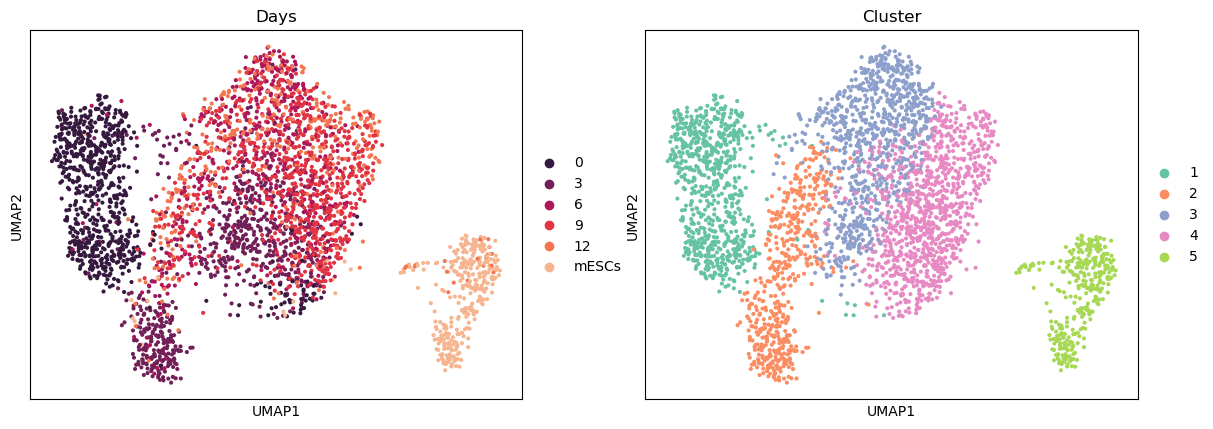

In [18]:
sc.pl.umap(adata_fbs, color=['day','cluster'], title = ['Days','Cluster'])

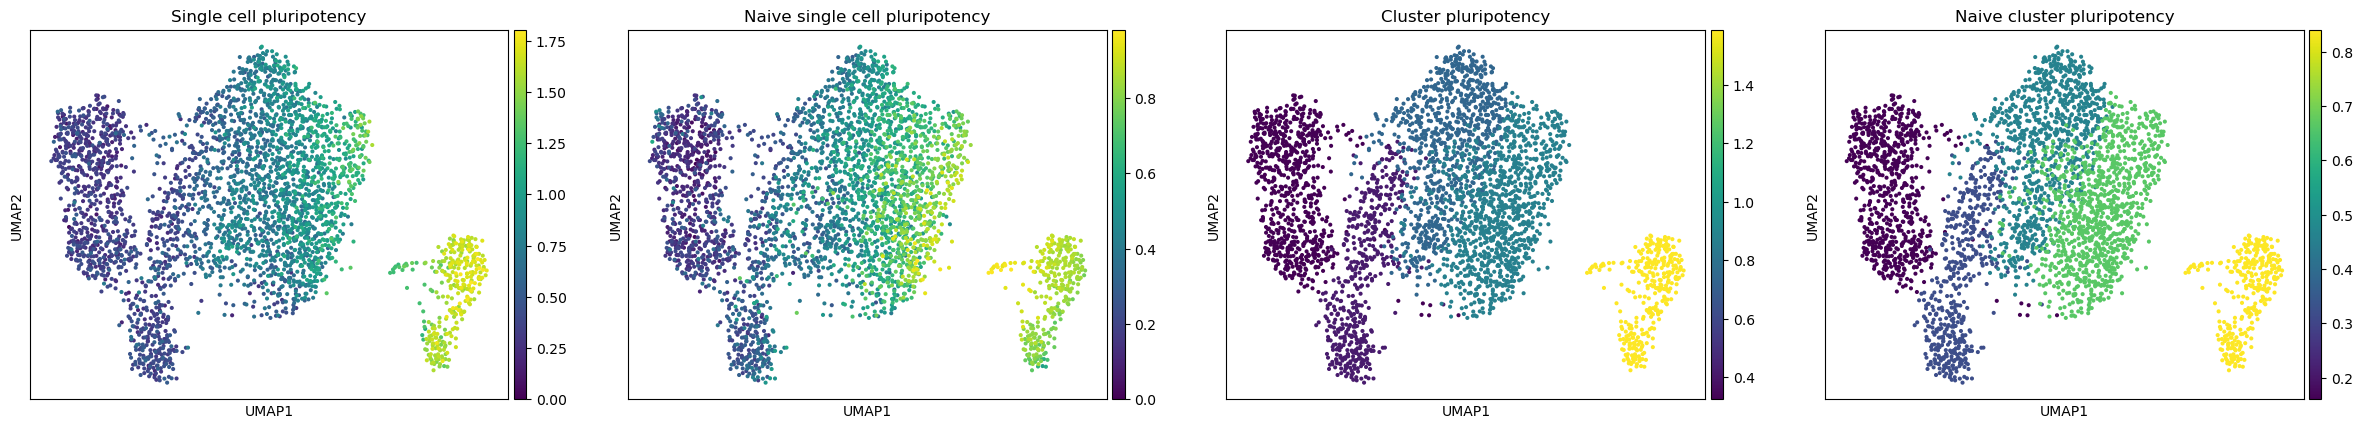

In [19]:
sc.pl.umap(adata_fbs, 
        color=['pluripotency','naive_pluripotency','cluster_pluripotency','cluster_naive_pluripotency'],
        title = ['Single cell pluripotency', 'Naive single cell pluripotency','Cluster pluripotency','Naive cluster pluripotency'])

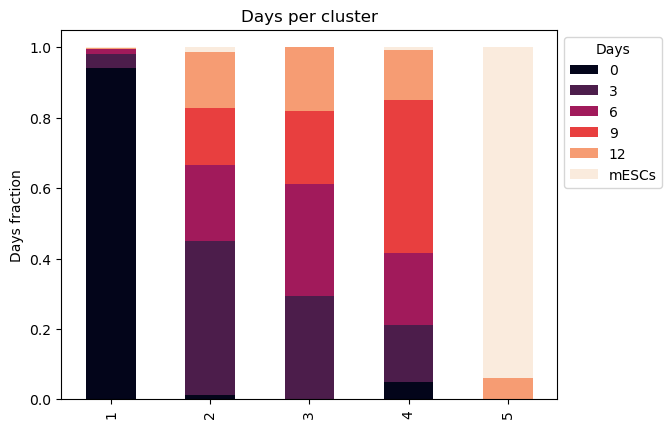

In [20]:
stackbar_days(adata_fbs)

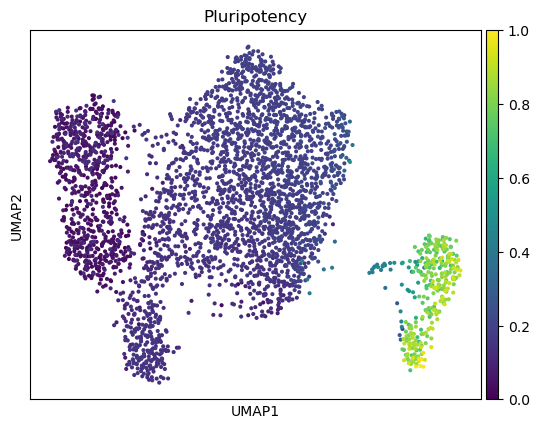

/Users/maddalenastaiano/opt/anaconda3/envs/ideas_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


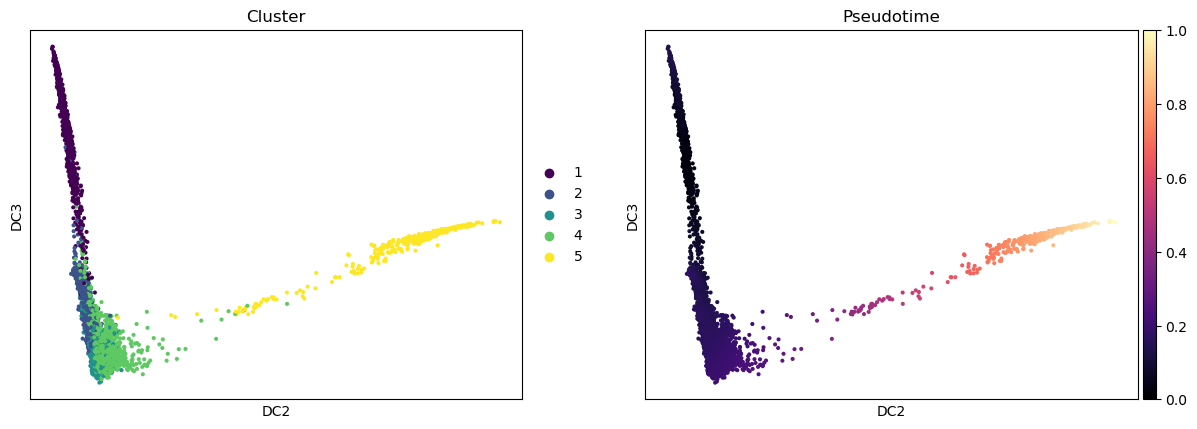

In [21]:
# add pseudotime

#go back to RAW counts
raw_adata_fbs = raw_adata[adata_fbs.obs_names]
adata_fbs.X = raw_adata_fbs.X

adata_fbs = pseudotime_fbs(adata_fbs)
sc.pl.umap(adata_fbs, color='dpt_pseudotime', title='Pluripotency', cmap='viridis')
fig, axes = sc.pl.diffmap(adata_fbs, 
              color=['cluster','dpt_pseudotime'], 
              dimensions=[(1, 2)],
              title = ['Cluster', 'Pseudotime'],
              legend_fontsize = 10,
              palette = 'viridis',
              cmap = 'magma',
              show=False,
              
                          
)
plt.rcParams['axes.titlesize'] = 16

plt.show()

In [23]:
#save results (with raw counts)

adata_fbs.X = raw_adata_fbs.X
for key in ["day_colors", "pluripotency_colors", "cluster_colors"]:
    if key in adata_fbs.uns and isinstance(adata_fbs.uns[key], mcolors.ListedColormap):
        adata_fbs.uns[key] = adata_fbs.uns[key].colors
#adata_fbs.write('../Datasets/FBS_IDEAS.h5ad')


fig, axes = sc.pl.diffmap(adata_fbs, 
              color=['cluster','dpt_pseudotime'], 
              dimensions=[(1, 2)],
              title = ['Cluster', 'Pseudotime'],
              legend_fontsize = 10,
              palette = 'viridis',
              cmap = 'magma',
              legend_loc=None,
              show=False,
              
                          
)
plt.rcParams['axes.titlesize'] = 16

axes.text(-0.118, 0.03,'1', fontweight = 'bold', fontsize = '20', 
             color = 'purple', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes.text(-0.127, 0.002,'2',  fontweight = 'bold', fontsize = '20', 
             color = 'darkblue', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes.text(-0.124, -0.02,'3',fontweight = 'bold', fontsize = '20', 
             color = 'tab:blue', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes.text(-0.10, -0.015,'4', fontweight = 'bold', fontsize = '20', 
             color = 'green', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes.text(-0.06, 0.00,'5', fontweight = 'bold', fontsize = '20', 
             color = 'orange', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))


plt.show()


## A2S

In [24]:
#leiden clustering and umap coordinates are added as obs and obsm in the anndata object
add_cluster_and_umap(adata_a2s)

#cluster smaller that 1% of total cell counts are removed
adata_a2s = remove_small_clusters(adata_a2s)

#pluripotency score is computed and added in the obs of the anndata object
genes_dict, genes = import_differentiation_markers()

#compute single cell pluripotency
compute_pluripotency(adata_a2s, genes)
compute_naive_pluripotency(adata_a2s, genes)

#compute cluster pluripotency as mean value of single cell pluripotency
cluster_pluripotency = adata_a2s.obs.groupby("cluster")["pluripotency"].transform("mean")
adata_a2s.obs["cluster_pluripotency"] = cluster_pluripotency

cluster_naive_pluripotency = adata_a2s.obs.groupby("cluster")["naive_pluripotency"].transform("mean")
adata_a2s.obs["cluster_naive_pluripotency"] = cluster_naive_pluripotency

# order clusters according to their mean pluripotency
dict_pluripotency = adata_a2s.obs.groupby("cluster")["cluster_pluripotency"].first().to_dict()
adata_a2s = rename_clusters(adata_a2s, dict_pluripotency)

/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_62548/3773130730.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Adata.obs['cluster'] = Adata_hv.obs['leiden']


(array(['0', '1', '2', '3', '4', '5'], dtype=object), array([743, 708, 299, 292, 244, 122]))


/Users/maddalenastaiano/opt/anaconda3/envs/ideas_env/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


/Users/maddalenastaiano/opt/anaconda3/envs/ideas_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/maddalenastaiano/opt/anaconda3/envs/ideas_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


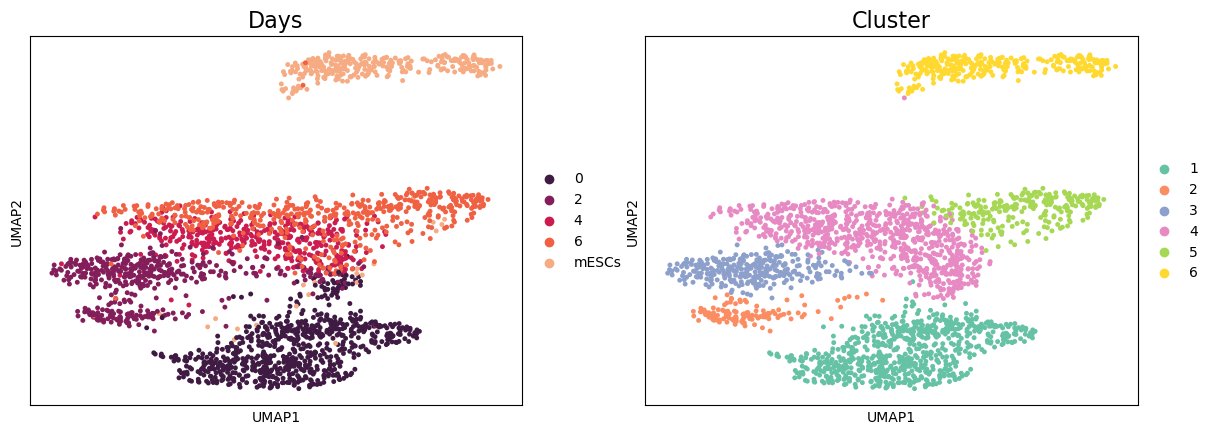

In [25]:
sc.pl.umap(adata_a2s, color=['day','cluster'], title = ['Days','Cluster'], components = ['1,2'])

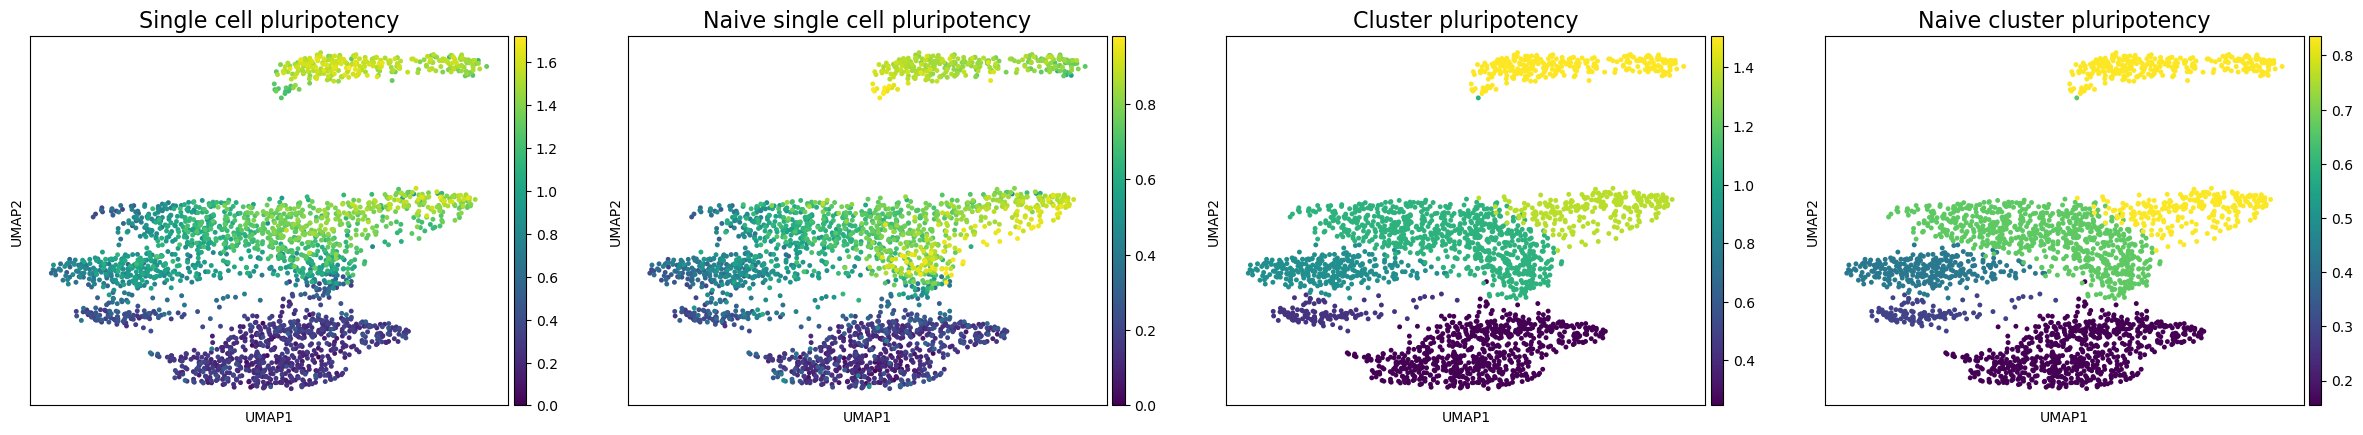

In [26]:
sc.pl.umap(adata_a2s, 
        color=['pluripotency','naive_pluripotency','cluster_pluripotency','cluster_naive_pluripotency'],
        title = ['Single cell pluripotency', 'Naive single cell pluripotency','Cluster pluripotency','Naive cluster pluripotency'])

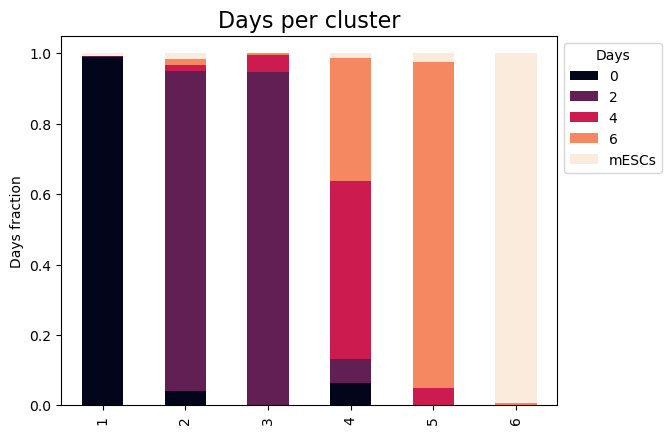

In [27]:
stackbar_days(adata_a2s)

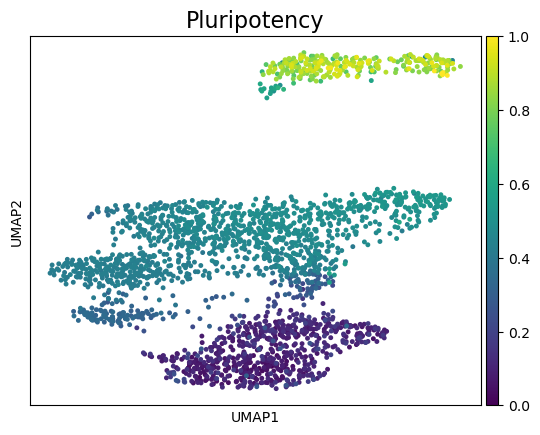

/Users/maddalenastaiano/opt/anaconda3/envs/ideas_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


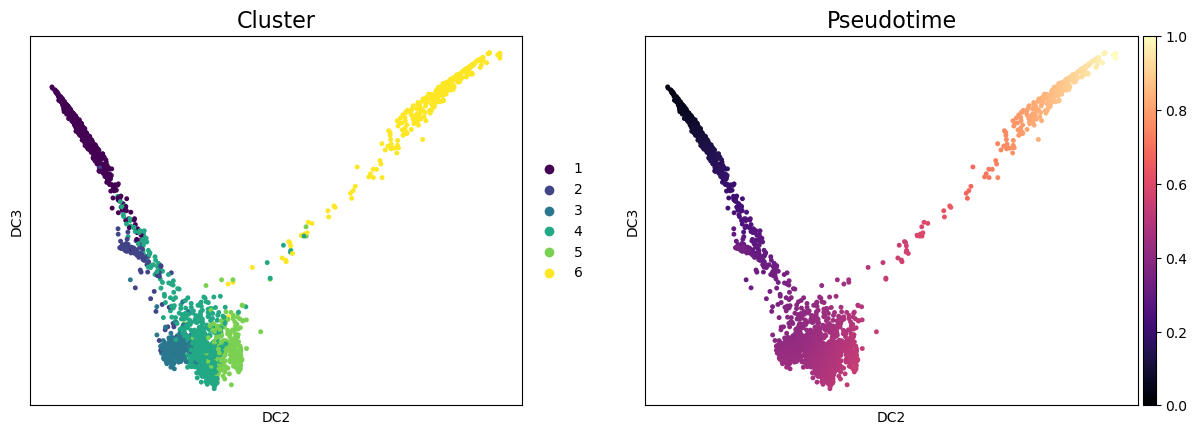

In [28]:
# add pseudotime

#go back to RAW counts
raw_adata_a2s = raw_adata[adata_a2s.obs_names]
adata_a2s.X = raw_adata_a2s.X

adata_a2s = pseudotime_a2s(adata_a2s)
sc.pl.umap(adata_a2s, color='dpt_pseudotime', title='Pluripotency', cmap='viridis')
fig, axes = sc.pl.diffmap(adata_a2s, 
              color=['cluster','dpt_pseudotime'], 
              dimensions=[(1, 2)],
              title = ['Cluster', 'Pseudotime'],
              legend_fontsize = 10,
              palette = 'viridis',
              cmap = 'magma',
              show=False,
              
                          
)
plt.rcParams['axes.titlesize'] = 16

plt.show()

In [29]:
#save results (with raw counts)

adata_a2s.X = raw_adata_a2s.X
for key in ["day_colors", "pluripotency_colors", "cluster_colors"]:
    if key in adata_a2s.uns and isinstance(adata_a2s.uns[key], mcolors.ListedColormap):
        adata_a2s.uns[key] = adata_a2s.uns[key].colors
#adata_a2s.write('../Datasets/A2S_IDEAS.h5ad')